In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

from matplotlib import pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh import palettes
from bokeh.models import Legend

%matplotlib inline
output_notebook()

Loading BokehJS ...

## PCA

In [2]:
t0 = time.time()
df = pd.read_hdf("./data/mRNA_lognorm_StandardScaled.hdf", 
                 index_col="sample_id")
print("loading matrix takes {0} seconds".format(time.time()-t0))

loading matrix takes 2.1198835372924805 seconds


In [3]:
pca = PCA()
t0 = time.time()
pca.fit(df.as_matrix())
print("fitting PCA to this matrix takes {0} seconds".format(time.time()-t0))

fitting PCA to this matrix takes 1162.0474202632904 seconds


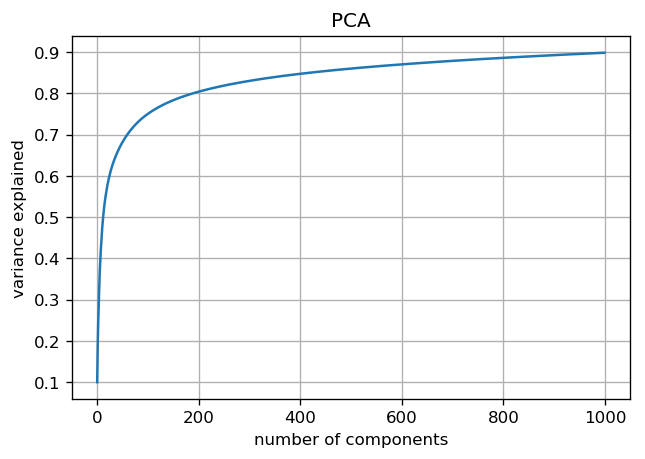

In [4]:
fig = plt.figure(dpi=120)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:1000])
plt.ylabel("variance explained")
plt.title("PCA")
plt.grid()
plt.xlabel("number of components")

In [5]:
# get number of components where 60%, 70%, 80% and 90% of of variations are preserved
def get_n_component_for_x_variance(x, variance_list):
    for i, variance in enumerate(variance_list):
        if variance > x:
            return i 
variance_preserved = np.cumsum(pca.explained_variance_ratio_)

variance_dict = {}
for variance in [0.2, 0.6,0.7,0.8,0.9]:
    variance_dict[variance] = get_n_component_for_x_variance(variance, variance_preserved)
print(variance_dict)

{0.2: 2, 0.6: 25, 0.7: 60, 0.8: 189, 0.9: 1028}


In [6]:
X_tranformed = pca.transform(df)

In [7]:
for variance, n in variance_dict.items():
    df_PCA = pd.DataFrame(X_tranformed[:, :n], index=df.index)
    df_PCA.to_csv("./data/mRNA_PCA_{0}_variance.csv".format(variance))

### Histogram of PCA processed data

variance=0.2, n_components=2


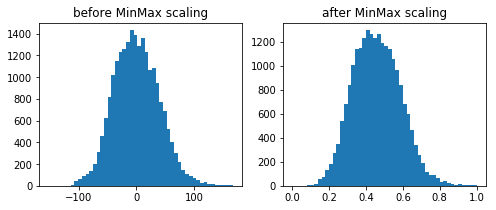

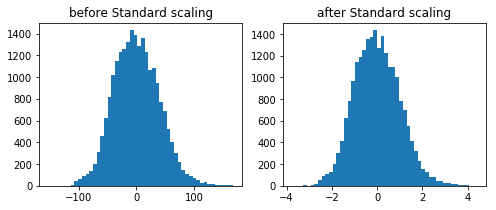

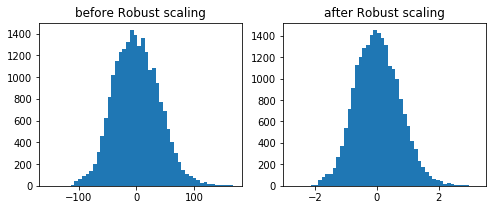

variance=0.6, n_components=25


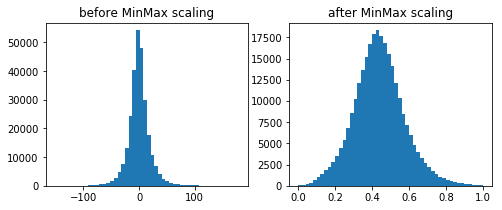

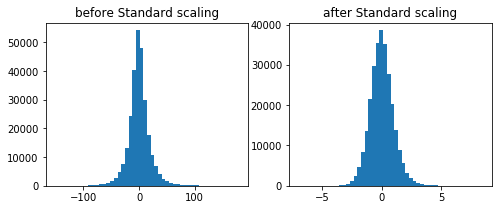

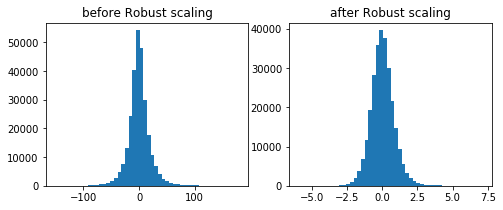

variance=0.7, n_components=60


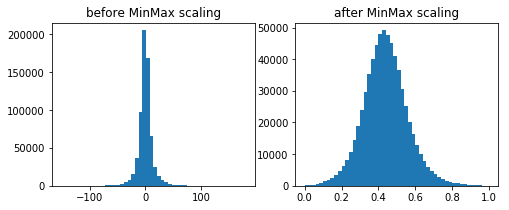

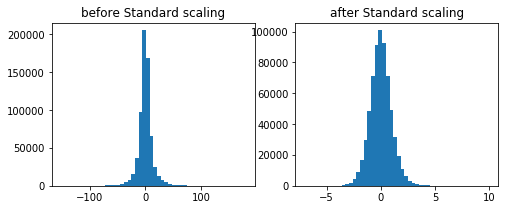

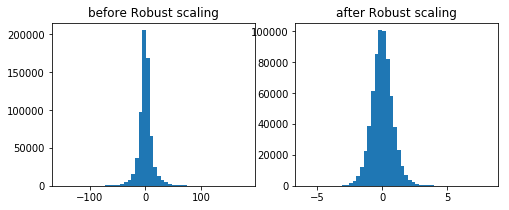

variance=0.8, n_components=189


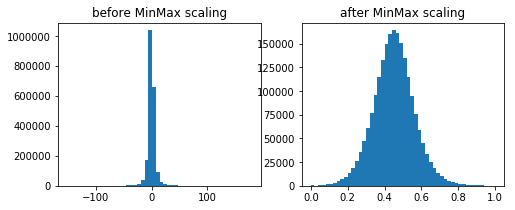

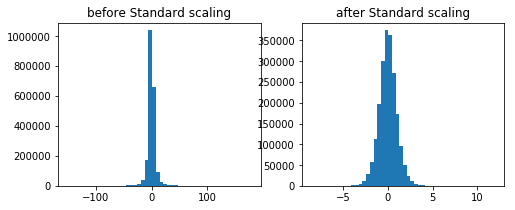

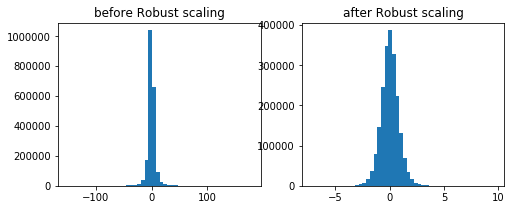

variance=0.9, n_components=1028


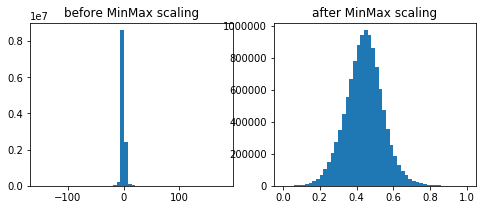

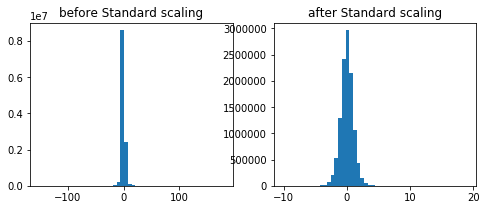

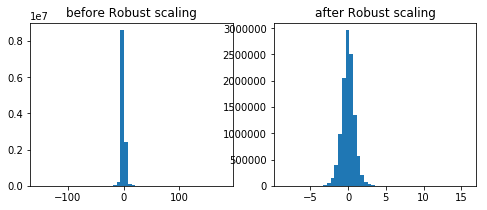

In [8]:
scalers = {"MinMax": MinMaxScaler(), "Standard": StandardScaler(), "Robust": RobustScaler()}
for variance, n in variance_dict.items():
    print("variance={0}, n_components={1}".format(variance, n))
    df= pd.read_csv("./data/mRNA_PCA_{0}_variance.csv".format(variance), 
                    index_col="sample_id")
    for scaler_name, scaler in scalers.items():    
        X_transform = scaler.fit_transform(df)
        f, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].hist(df.as_matrix().flatten(), bins=50)
        axes[0].set_title("before {0} scaling".format(scaler_name))
        axes[1].hist(X_transform.flatten(), bins=50)
        axes[1].set_title("after {0} scaling".format(scaler_name))
        plt.show()
        # saved transformed PCA results
        df_scaled = pd.DataFrame(X_transform, index=df.index, columns=df.columns)
        df_scaled.to_csv("./data/mRNA_PCA_{0}_variance_{1}Scaled.csv".format(variance, scaler_name))

### Plot first two components of PCA

In [10]:
df2 = pd.read_csv("./data/mRNA_PCA_0.2_variance_StandardScaled.csv", index_col="sample_id")
label_df = pd.read_csv("./data/labels.csv", index_col="sample_id")
joined_df = label_df.join(df2).dropna()

In [12]:
p = figure(plot_width=800, plot_height=700)
colors = palettes.Category10[10]
for i, datatype in enumerate(set(joined_df["label_gender"])):
    subset_df = joined_df[joined_df["label_gender"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, color=colors[i], alpha=0.6, legend=datatype)
p.legend.click_policy="hide"
show(p)

In [15]:
colored_tissues = joined_df["label_tissue"].value_counts().index[:20]
rest_of_tissues = joined_df["label_tissue"].value_counts().index[20:]

p = figure(plot_width=800, plot_height=700)
colors = palettes.Category20[20]
for i, datatype in enumerate(colored_tissues):
    subset_df = joined_df[joined_df["label_tissue"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, color=colors[i], legend=datatype)
    
for i, datatype in enumerate(rest_of_tissues):
    subset_df = joined_df[joined_df["label_tissue"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, color="grey", legend="Others")
    
p.legend.click_policy="hide"
p.legend.location = "bottom_left"
show(p)

In [20]:
p = figure(plot_width=800, plot_height=700)
colors = palettes.Category10[10]
for i, datatype in enumerate(sorted(list(set(joined_df["label_tumor"])))):
    subset_df = joined_df[joined_df["label_tumor"] == datatype]
    p.circle(subset_df["0"], subset_df["1"], size=3, alpha=0.8,
             color=colors[i], legend=datatype)
p.legend.click_policy="hide"
show(p)